In [1]:
# CMIP6 abrupt-0p5xCO₂ and MAGICC6
##### CC-BY 4.0 2020 @safiume, https://github.com/hsbay/cdrmex¶

##### Abrupt .5% decrease in CO₂ concentration

##### Pymagicc https://pymagicc.readthedocs.io/ AGPL-3.0,
##### and MAGICC6, http://www.magicc.org/download6, CC-BY-NC-SA-4.0,
##### CDR calibration file and experiment
##### See the CMIP6 Licenses inline for more details

In [2]:
# NBVAL_IGNORE_OUTPUT
import os
from os.path import join
from datetime import datetime
import sys, dateutil
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
%matplotlib inline
print("Python verison:", sys.version)

import glob
import requests
import shutil
import netcdf_scm.io
import netcdf_scm.citing
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tqdm.autonotebook as tqdman
from patsy import dmatrices
from openscm_units import unit_registry
from scmdata import ScmRun, run_append


Python verison: 3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler
/Users/shannon/workbench/pymagicc_1.3.2/venv/lib/python3.7/site-packages/netcdf_scm/errors.py:19: UserWarning: A compatible version of Iris is not installed, not all functionality will work. We recommend installing the lastest version of Iris using conda to address this.
  warnings.warn(warn_msg)
/Users/shannon/workbench/pymagicc_1.3.2/venv/lib/python3.7/site-packages/netcdf_scm/citing/__init__.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [3]:
import pymagicc
from pymagicc import MAGICC6, rcp26
from pymagicc.io import MAGICCData

print("Pymagicc version:", pymagicc.__version__)
print("Scenario API", rcp26.__class__.__bases__)

Pymagicc version: 2.0.0rc8+19.g7aade1e.dirty
Scenario API (<class 'scmdata.run.ScmRun'>,)


In [4]:
graphstart = 1849
graphend = 2101
CDR_DIR = "CDRRUN"
co2_conc_filename = "ABRUPT0P5XCO2_CO2_CONC.IN"
pymgc_hm = "pymagicc_1.3.2"

# Turn off emissions caculations by forcing emissions
# to switch on post experiment. Climate sensitivity 
# can be tuned to emulate ESMs.

# See 'Reduced complexity model intercomparison project phase 
# 1: Protocol, results and initial observations' 
# https://doi.org/10.5194/gmd-2019-375 for more details on 
# calibrating.

magcfg = {
    'co2_switchfromconc2emis_year': 5000,
    'co2_tempfeedback_switch': 1,
    'rf_total_runmodus':"CO2",
    'rf_total_constantafteryr': 5000,
    'startyear' : 1850,
    'endyear': 2100,
    'core_climatesensitivity' : 2.6144,
    'out_inverseemis': 1,
}

vars = ["Surface Temperature", "tas",
        "Radiative Forcing",
        "Atmospheric Concentrations|CO2"]

In [5]:
# Copy abrupt-0p5xCO₂ idealized file to pymagicc/MAGICC6/run
# to workaround pathing in magicc.run and magiccdata file writing
# not able to be read by magicc. 
# Uncomment and run once. Hit stop in jupyter to cancel this cell.

#!cp -i $CDR_DIR/$co2_conc_filename ../$pymgc_hm/pymagicc/MAGICC6/run

In [6]:
# RCMIP CMIP included data
# CMIP and experiment data Licensing
with open(os.path.join(CDR_DIR, "README.txt"), "r") as fh:
    print(fh.read())

README
------

Acknowledging CMIP

The data provided here are derived from the outputs of the `Coupled Model Intercomparison Project <https://www.wcrp-climate.org/wgcm-cmip>`_ data.
This means that you **must** abide by the terms of use of the data, in particular the required acknowledgement statements (see the `CMIP5 terms of use <https://pcmdi.llnl.gov/mips/cmip5/terms-of-use.html>`_ and `CMIP6 terms of use <https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html>`_).

To make it easier to do this, we have developed some basic tools which simplify the process of checking model license terms and creating the tables required in publications to cite CMIP data (see the `our tools here <https://netcdf-scm.readthedocs.io/en/latest/usage/using-cmip-data.html>`_).
However, we provide no guarantees that these tools are up to date so all users should double check that they do in fact produce output consistent with the terms of use referenced above (and if there are issues, please raise an i

In [7]:
cexp_fh = glob.glob(os.path.join(CDR_DIR, "**", "*.MAG"), recursive=True)
print(f"{len(cexp_fh)} CMIP Experiment Results Files")
cexp_fh[:2]

7 CMIP Experiment Results Files


['CDRRUN/average-year-mid-year/CMIP6/CFMIP/MIROC/MIROC6/abrupt-0p5xCO2/r1i1p1f1/Amon/tas/gn/v20190705/netcdf-scm_tas_Amon_MIROC6_abrupt-0p5xCO2_r1i1p1f1_gn_3200-3449.MAG',
 'CDRRUN/average-year-mid-year/CMIP6/CFMIP/NCAR/CESM2/abrupt-0p5xCO2/r1i1p1f1/Amon/tas/gn/v20200408/netcdf-scm_tas_Amon_CESM2_abrupt-0p5xCO2_r1i1p1f1_gn_0001-0150.MAG']

In [8]:
db = [
    netcdf_scm.io.load_mag_file(f, "CMIP6Output" if "CMIP6" in f else "MarbleCMIP5")
    for f in tqdman.tqdm(cexp_fh)
]

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
citation_res = netcdf_scm.citing.get_citation_tables(db)

Datasets:   0%|          | 0/7 [00:00<?, ?it/s]

Dependencies:   0%|          | 0/3 [00:00<?, ?it/s]

Dependencies:   0%|          | 0/3 [00:00<?, ?it/s]

Dependencies:   0%|          | 0/1 [00:00<?, ?it/s]

Dependencies:   0%|          | 0/3 [00:00<?, ?it/s]

Dependencies:   0%|          | 0/3 [00:00<?, ?it/s]

Dependencies:   0%|          | 0/3 [00:00<?, ?it/s]

Dependencies:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
citation_res["cmip6_references"]

,,,Reference
Modelling Group,Climate Model,Scenario,
CNRM-CERFACS,CNRM-CM6-1,abrupt-0p5xCO2,\citet{cmip6data_CMIP6_CFMIP_CNRM-CERFACS_CNRM...
IPSL,IPSL-CM6A-LR,abrupt-0p5xCO2,\citet{cmip6data_CMIP6_CFMIP_IPSL_IPSL-CM6A-LR...
MIROC,MIROC6,abrupt-0p5xCO2,\citet{cmip6data_CMIP6_CFMIP_MIROC_MIROC6_abru...
MOHC,HadGEM3-GC31-LL,abrupt-0p5xCO2,\citet{cmip6data_CMIP6_CFMIP_MOHC_HadGEM3-GC31...
MRI,MRI-ESM2-0,abrupt-0p5xCO2,\citet{cmip6data_CMIP6_CFMIP_MRI_MRI-ESM2-0_ab...
NASA-GISS,GISS-E2-1-G,abrupt-0p5xCO2,\citet{cmip6data_CMIP6_CFMIP_NASA-GISS_GISS-E2...
NCAR,CESM2,abrupt-0p5xCO2,\citet{cmip6data_CMIP6_CFMIP_NCAR_CESM2_abrupt...


In [11]:
print("\n\n".join(citation_res["cmip6_bibtex"]))

@misc{cmip6data_CMIP6_CFMIP_NCAR_CESM2_abrupt-0p5xCO2,
  doi = {10.22033/ESGF/CMIP6.7517},
  url = {http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6.CFMIP.NCAR.CESM2.abrupt-0p5xCO2},
  author = {Danabasoglu, Gokhan},
  keywords = {CMIP6, climate, CMIP6.CFMIP.NCAR.CESM2.abrupt-0p5xCO2},
  language = {en},
  title = {NCAR CESM2 model output prepared for CMIP6 CFMIP abrupt-0p5xCO2. Version v20200408},
  publisher = {Earth System Grid Federation},
  year = {2020},
  copyright = {Creative Commons Attribution Share Alike 4.0 International}
}


@misc{cmip6data_CMIP6_CFMIP_IPSL_IPSL-CM6A-LR_abrupt-0p5xCO2,
  doi = {10.22033/ESGF/CMIP6.5106},
  url = {http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6.CFMIP.IPSL.IPSL-CM6A-LR.abrupt-0p5xCO2},
  author = {Boucher, Olivier and Denvil, Sébastien and Levavasseur, Guillaume and Cozic, Anne and Caubel, Arnaud and Foujols, Marie-Alice and Meurdesoif, Yann and Bony, Sandrine and Flavoni, Simona and Idelkadi, Abderrahmane and Mellul, Lidia and Musat, Ionela and 

In [12]:
db = run_append(db)

In [13]:
#db.filter(region=["World", "World|*sphere", "World|*sphere|*", 
#                  "World|Land", "World|Ocean", "World|*Ocean", 
#                  "World|*Land", "World|*Nino*"]).timeseries().loc[:,:datetime(3452,1,1,0)]

In [14]:
cmip_mntas_wld = db.filter(region=["World"]).timeseries().loc[:,datetime(1,1,1,0):datetime(3501,1,1,0)]

In [15]:
cesm2 = ('CFMIP','CESM2','r1i1p1f1','CMIP6','unspecified', 'World','abrupt-0p5xCO2','K','tas')
CESM2data = cmip_mntas_wld.loc[cesm2,datetime(1,7,1,0):datetime(150,7,1,0)]
cmip_mntas_wld.loc[cesm2, datetime(1850,7,1,0):datetime(1999,7,1,0)] = CESM2data.values
miroc6 = ('CFMIP','MIROC6','r1i1p1f1','CMIP6','unspecified', 'World','abrupt-0p5xCO2','K','tas')
miroc6data = cmip_mntas_wld.xs(miroc6)[datetime(3200,7,1,0):datetime(3449,7,1,0)]
cmip_mntas_wld.loc[miroc6, datetime(1850,7,1,0):datetime(2000,7,1,0)] = miroc6data.values[0:151]

In [16]:
twodt = []
for n in np.arange(2001, 2100):
    twodt.append(datetime(n,7,1,0))
cmip_mntas_wld[twodt] = 'NaN'
len(miroc6data.values[0:250])

250

In [17]:
cmip_mntas_wld.loc[miroc6, datetime(2001,7,1,0):datetime(2099,7,1,0)] = miroc6data.values[151:250]
cmip_mntas_wld = cmip_mntas_wld.sort_index(axis=1).loc[:,datetime(1850,7,1,0):datetime(2099,7,1,0)]

In [18]:
# Date range for graphs
x = (datetime(graphstart, 1, 1), datetime(graphend, 1, 1))

# Adjust baseline temp to the mean of 1720 to 1800 
# per https://doi.org/10.1175/BAMS-D-16-0007.1
#
# Reassign startyear to include the year 1720.
if magcfg['startyear'] > 1720:
    magcfg['startyear'] = 1720

styr = 1720
eyr = 1800

selectftr = {
    "region": "World",
    "variable": "Surface Temperature",
    "year": range(magcfg["startyear"], magcfg["endyear"]),
}

def meanbln(scen,mgdata,**mcfg):
    origts = mgdata.timeseries()
    default = magicc.run(file_co2_conc=scen, **mcfg)
    pmean = default.filter(**selectftr).timeseries().loc[:,datetime(styr, 1, 1): datetime(eyr, 1, 1)].T.mean()
    defaultts = default.timeseries()
    updated = defaultts.xs((selectftr['variable']),level = ('variable'), drop_level=False).add(pmean[0])
    origts.loc[updated.index.values] = updated
    return(MAGICCData(origts.copy()))

In [19]:
# Run MAGICC6
with MAGICC6() as magicc:
    tests = magicc.run(file_co2_conc = co2_conc_filename, **magcfg)
    res = meanbln(co2_conc_filename, tests, **magcfg)

In [20]:
# Add CMIP data to results for plotting
res = res.append(cmip_mntas_wld)

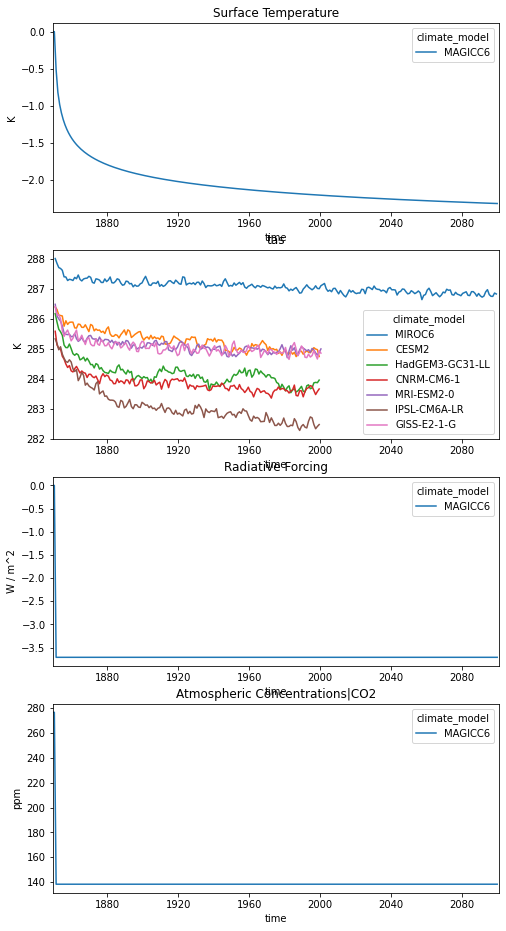

In [21]:
fig, axes = plt.subplots((len(vars)), 1, figsize=(8, 16))
for n, var in enumerate(vars):
    res.filter(variable=var,region='World').lineplot(hue="climate_model", ax=axes[n])
    ylab = res.filter(variable=var)["unit"].iloc[[0]].all()
    axes[n].set_ylabel(ylab)
    axes[n].set_title(var)                        
    axes[n].set_xlim(x)

In [48]:
exspan = res.filter(
    variable=["Surface Temperature", "Atmospheric Concentrations|CO2", "tas"], region="World"
).timeseries().loc[:, (datetime(1849, 1, 1, 0)) : (datetime(2100, 7, 1, 0))]

In [49]:
# Print out Diagnostic output
# extract start and endpoints of the experiments
exs = exspan[[datetime(1850, 1, 1, 0),datetime(1850, 7, 1, 0),
        datetime(1999, 1, 1, 0),datetime(1999, 7, 1, 0),
        datetime(2000, 1, 1, 0),datetime(2000, 7, 1, 0),
        datetime(2001, 1, 1, 0),datetime(2001, 7, 1, 0),
        datetime(2099, 1, 1, 0),datetime(2099, 7, 1, 0)]]
exs

time                                                                                                                              1850-01-01  \
activity_id climate_model   member_id mip_era model       region scenario       todo         unit variable                                     
NaN         MAGICC6         NaN       NaN     unspecified World  unspecified    not_relevant ppm  Atmospheric Concentrations|CO2     276.744   
                                                                                             K    Surface Temperature                  0.000   
CFMIP       MIROC6          r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            CESM2           r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            HadGEM3-GC31-LL r1i1p1f3  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            CNRM-CM6-1      r1i1p1f2  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            MRI-ESM2-0      r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            IPSL-CM6A-LR    r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            GISS-E2-1-G     r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   

time                                                                                                                              1850-07-01  \
activity_id climate_model   member_id mip_era model       region scenario       todo         unit variable                                     
NaN         MAGICC6         NaN       NaN     unspecified World  unspecified    not_relevant ppm  Atmospheric Concentrations|CO2         NaN   
                                                                                             K    Surface Temperature                    NaN   
CFMIP       MIROC6          r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                288.001   
            CESM2           r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                286.388   
            HadGEM3-GC31-LL r1i1p1f3  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                286.168   
            CNRM-CM6-1      r1i1p1f2  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                285.581   
            MRI-ESM2-0      r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                286.478   
            IPSL-CM6A-LR    r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                285.329   
            GISS-E2-1-G     r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                286.398   

time                                                                                                                              1999-01-01  \
activity_id climate_model   member_id mip_era model       region scenario       todo         unit variable                                     
NaN         MAGICC6         NaN       NaN     unspecified World  unspecified    not_relevant ppm  Atmospheric Concentrations|CO2  138.372000   
                                                                                             K    Surface Temperature              -2.210199   
CFMIP       MIROC6          r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            CESM2           r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas         

In [94]:
# Extract only the deltas between the experiment start and end times
# MIROC6 was moved from 3200-3449 AD to 1850-2099 AD, and has timepts for 2000 and 2099.

hdr = exs.index
delta = pd.DataFrame( index = hdr )
for yr in 1999, 2000, 2099:
    delta[yr] = 0
    for mo in 7,1:
        if mo == 1:
            delta[yr][0:2] = exs[datetime(yr, mo, 1)][0:2].values - exs[datetime(1850, mo, 1)][0:2].values
        else :
            delta[yr][2:9] = exs[datetime(yr, mo, 1)][2:9].values - exs[datetime(1850, mo, 1)][2:9].values

print('Deltas from 1850 experiment start and 1999, 2000, and 2099 AD.')
delta

Deltas from 1850 experiment start and 1999, 2000, and 2099 AD.


/Users/shannon/workbench/pymagicc_1.3.2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1999  \
activity_id climate_model   member_id mip_era model       region scenario       todo         unit variable                                     
NaN         MAGICC6         NaN       NaN     unspecified World  unspecified    not_relevant ppm  Atmospheric Concentrations|CO2 -138.372000   
                                                                                             K    Surface Temperature              -2.210199   
CFMIP       MIROC6          r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -1.004000   
            CESM2           r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -1.646000   
            HadGEM3-GC31-LL r1i1p1f3  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -2.210000   
            CNRM-CM6-1      r1i1p1f2  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -1.918000   
            MRI-ESM2-0      r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -1.600000   
            IPSL-CM6A-LR    r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -2.850000   
            GISS-E2-1-G     r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -1.461000   

                                                                                                                                        2000  \
activity_id climate_model   member_id mip_era model       region scenario       todo         unit variable                                     
NaN         MAGICC6         NaN       NaN     unspecified World  unspecified    not_relevant ppm  Atmospheric Concentrations|CO2 -138.372000   
                                                                                             K    Surface Temperature              -2.211731   
CFMIP       MIROC6          r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -0.904000   
            CESM2           r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            HadGEM3-GC31-LL r1i1p1f3  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            CNRM-CM6-1      r1i1p1f2  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            MRI-ESM2-0      r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -1.483000   
            IPSL-CM6A-LR    r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN   
            GISS-E2-1-G     r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -1.543000   

                                                                                                                                        2099  
activity_id climate_model   member_id mip_era model       region scenario       todo         unit variable                                    
NaN         MAGICC6         NaN       NaN     unspecified World  unspecified    not_relevant ppm  Atmospheric Concentrations|CO2 -138.372000  
                                                                                             K    Surface Temperature              -2.323843  
CFMIP       MIROC6          r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                              -1.179000  
            CESM2           r1i1p1f1  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas                                    NaN  
            HadGEM3-GC31-LL r1i1p1f3  CMIP6   unspecified World  abrupt-0p5xCO2 NaN          K    tas       